Based on:

@book{leborgne2022fraud,

title={Reproducible Machine Learning for Credit Card Fraud Detection - Practical Handbook},

author={Le Borgne, Yann-A{\"e}l and Siblini, Wissam and Lebichot, Bertrand and Bontempi, Gianluca},

url={https://github.com/Fraud-Detection-Handbook/fraud-detection-handbook},

year={2022},

publisher={Universit{\'e} Libre de Bruxelles}

}

Covered subchapters:
* 5.2 Validation strategies

In [1]:
import datetime
import sklearn
import time
import pandas as pd

In [2]:
%run ../shared_functions.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 63257  100 63257    0     0   162k      0 --:--:-- --:--:-- --:--:--  162k


In [3]:
DIR_INPUT = '../../fraud-detection-handbook/simulated-data-transformed/data/'

BEGIN_DATE = "2018-06-21"
END_DATE = "2018-09-04"

print("Load  files")
%time transactions_df=read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE)
print("{0} transactions loaded, containing {1} fraudulent transactions".format(len(transactions_df),transactions_df.TX_FRAUD.sum()))

Load  files
CPU times: total: 359 ms
Wall time: 520 ms
727766 transactions loaded, containing 6535 fraudulent transactions


##### Train test split

![train test split visualization](https://fraud-detection-handbook.github.io/fraud-detection-handbook/_images/stream_train_1block.png)

In [4]:
start_date_training = datetime.datetime.strptime("2018-07-25", "%Y-%m-%d")
delta_train = delta_delay = delta_test = 7

output_feature="TX_FRAUD"

input_features=['TX_AMOUNT','TX_DURING_WEEKEND', 'TX_DURING_NIGHT', 'CUSTOMER_ID_NB_TX_1DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW', 'CUSTOMER_ID_NB_TX_7DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW', 'CUSTOMER_ID_NB_TX_30DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW', 'TERMINAL_ID_NB_TX_1DAY_WINDOW',
       'TERMINAL_ID_RISK_1DAY_WINDOW', 'TERMINAL_ID_NB_TX_7DAY_WINDOW',
       'TERMINAL_ID_RISK_7DAY_WINDOW', 'TERMINAL_ID_NB_TX_30DAY_WINDOW',
       'TERMINAL_ID_RISK_30DAY_WINDOW']

In [5]:
def get_performances_train_test_sets(transactions_df, classifier,
                                     input_features, output_feature,
                                     start_date_training, 
                                     delta_train=7, delta_delay=7, delta_test=7,
                                     top_k_list=[100],
                                     type_test="Test", parameter_summary=""):

    (train_df, test_df)=get_train_test_set(transactions_df,start_date_training,
                                           delta_train=delta_train,
                                           delta_delay=delta_delay,
                                           delta_test=delta_test)
    
    start_time=time.time() 
    model_and_predictions_dictionary = fit_model_and_get_predictions(classifier, train_df, test_df, 
                                                                     input_features, output_feature)
    execution_time=time.time()-start_time
    
    test_df['predictions']=model_and_predictions_dictionary['predictions_test']
    performances_df_test=performance_assessment(test_df, top_k_list=top_k_list)
    performances_df_test.columns=performances_df_test.columns.values+' '+type_test
    
    train_df['predictions']=model_and_predictions_dictionary['predictions_train']
    performances_df_train=performance_assessment(train_df, top_k_list=top_k_list)
    performances_df_train.columns=performances_df_train.columns.values+' Train'
    
    performances_df=pd.concat([performances_df_test,performances_df_train],axis=1)
    
    performances_df['Execution time']=execution_time
    performances_df['Parameters summary']=parameter_summary
    
    return performances_df

In [6]:
list_params = [2,3,4,5,6,7,8,9,10,20,50]

performances_df=pd.DataFrame()

for max_depth in list_params:
    classifier = sklearn.tree.DecisionTreeClassifier(max_depth = max_depth, random_state=0)

    performances_df=performances_df.append(
        get_performances_train_test_sets(transactions_df, classifier, 
                                         input_features, output_feature, 
                                         start_date_training=start_date_training, 
                                         delta_train=delta_train, 
                                         delta_delay=delta_delay, 
                                         delta_test=delta_test,            
                                         parameter_summary=max_depth
                           )
    )
    
performances_df.reset_index(inplace=True,drop=True)

In [7]:
performances_df

,AUC ROC Test,Average precision Test,Card Precision@100 Test,AUC ROC Train,Average precision Train,Card Precision@100 Train,Execution time,Parameters summary
0,0.763,0.496,0.241,0.802,0.586,0.394,0.158000,2
1,0.795,0.562,0.267,0.815,0.615,0.409,0.197999,3
2,0.802,0.570,0.269,0.829,0.635,0.411,0.244995,4
3,0.814,0.581,0.280,0.835,0.649,0.419,0.282998,5
4,0.817,0.588,0.280,0.842,0.662,0.421,0.322001,6
5,0.793,0.542,0.254,0.876,0.679,0.427,0.372000,7
6,0.786,0.546,0.257,0.884,0.717,0.436,0.412998,8
7,0.756,0.499,0.246,0.896,0.737,0.437,0.454002,9
8,0.750,0.484,0.244,0.901,0.756,0.440,0.495000,10
9,0.739,0.392,0.243,0.974,0.907,0.506,0.852999,20


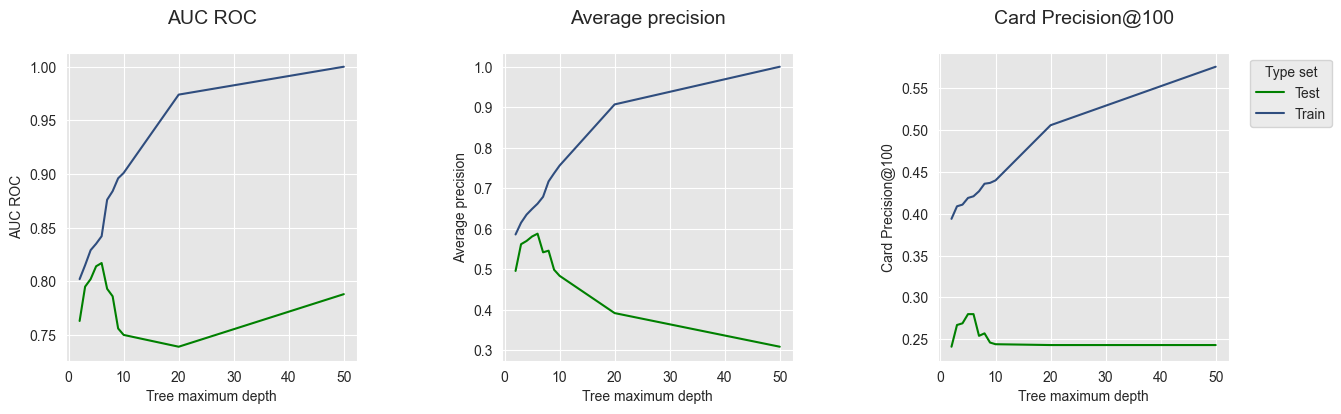

In [8]:
get_performances_plots(performances_df, 
                       performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100'], 
                       expe_type_list=['Test','Train'],expe_type_color_list=['#008000','#2F4D7E'])

"(...) Card Precision@100 is the metric that is of highest interest for fraud investigators. It is worth noting that the AUC ROC on the test set has a different dynamic than the CP@100: For the highest tree depth of fifty, the accuracy in terms of AUC ROC increases, whereas the CP@100 remains low. This illustrates experimentally that the AUC ROC is not a well-suited metric for fraud investigators"

##### Hold-out validation (train validation test split)

![Hold-out validation visualization](https://fraud-detection-handbook.github.io/fraud-detection-handbook/_images/stream_valid_1block.png)

In [9]:
classifier = sklearn.tree.DecisionTreeClassifier(max_depth = 2, random_state=0)

delta_valid = delta_test

start_date_training_with_valid = start_date_training+datetime.timedelta(days=-(delta_delay+delta_valid))

list_params = [2,3,4,5,6,7,8,9,10,20,50]

performances_df_validation=pd.DataFrame()

for max_depth in list_params:
    
    classifier = sklearn.tree.DecisionTreeClassifier(max_depth = max_depth, random_state=0)

    performances_df_validation=performances_df_validation.append(
        get_performances_train_test_sets(transactions_df, 
                                         classifier,
                                         input_features, output_feature,
                                         start_date_training=start_date_training_with_valid, 
                                         delta_train=delta_train, 
                                         delta_delay=delta_delay, 
                                         delta_test=delta_test, 
                                         type_test='Validation', parameter_summary=max_depth
                                        )
    )
    
performances_df_validation.reset_index(inplace=True,drop=True)

In [10]:
performances_df_validation

,AUC ROC Validation,Average precision Validation,Card Precision@100 Validation,AUC ROC Train,Average precision Train,Card Precision@100 Train,Execution time,Parameters summary
0,0.775,0.524,0.243,0.791,0.577,0.399,0.157002,2
1,0.778,0.538,0.247,0.803,0.604,0.413,0.199999,3
2,0.784,0.535,0.249,0.815,0.624,0.419,0.245002,4
3,0.791,0.533,0.257,0.824,0.642,0.430,0.283000,5
4,0.798,0.532,0.257,0.835,0.659,0.431,0.319000,6
5,0.804,0.537,0.256,0.848,0.671,0.434,0.357002,7
6,0.796,0.524,0.253,0.850,0.691,0.437,0.398000,8
7,0.781,0.473,0.249,0.852,0.699,0.437,0.441000,9
8,0.802,0.466,0.251,0.879,0.706,0.439,0.492000,10
9,0.775,0.445,0.259,0.967,0.849,0.481,0.891999,20


##### Repeated hold-out validation


In [11]:
def repeated_holdout_validation(transactions_df, classifier, 
                                start_date_training, 
                                delta_train=7, delta_delay=7, delta_test=7,
                                n_folds=4,
                                sampling_ratio=0.7,
                                top_k_list=[100],
                                type_test="Test", parameter_summary=""):

    performances_df_folds=pd.DataFrame()
    
    start_time=time.time() 
    
    for fold in range(n_folds):
        
        (train_df, test_df)=get_train_test_set(transactions_df,
                                               start_date_training,
                                               delta_train=delta_train,delta_delay=delta_delay,delta_test=delta_test,
                                               sampling_ratio=sampling_ratio,
                                               random_state=fold)
    
        
        model_and_predictions_dictionary = fit_model_and_get_predictions(classifier, train_df, test_df, 
                                                                         input_features, output_feature)
        
        test_df['predictions']=model_and_predictions_dictionary['predictions_test']
        performances_df_test=performance_assessment(test_df, top_k_list=top_k_list)
        performances_df_test.columns=performances_df_test.columns.values+' '+type_test
        
        train_df['predictions']=model_and_predictions_dictionary['predictions_train']
        performances_df_train=performance_assessment(train_df, top_k_list=top_k_list)
        performances_df_train.columns=performances_df_train.columns.values+' Train'
    
        performances_df_folds=performances_df_folds.append(pd.concat([performances_df_test,performances_df_train],axis=1))
    
    execution_time=time.time()-start_time
    
    performances_df_folds_mean=performances_df_folds.mean()
    performances_df_folds_std=performances_df_folds.std(ddof=0)
    
    performances_df_folds_mean=pd.DataFrame(performances_df_folds_mean).transpose()
    performances_df_folds_std=pd.DataFrame(performances_df_folds_std).transpose()
    performances_df_folds_std.columns=performances_df_folds_std.columns.values+" Std"
    performances_df=pd.concat([performances_df_folds_mean,performances_df_folds_std],axis=1)
    
    performances_df['Execution time']=execution_time
    
    performances_df['Parameters summary']=parameter_summary
    
    return performances_df, performances_df_folds

In [12]:
list_params = [2,3,4,5,6,7,8,9,10,20,50]

performances_df_repeated_holdout=pd.DataFrame()

start_time=time.time()

for max_depth in list_params:
    
    print("Computing performances for a decision tree with max_depth="+str(max_depth))
    
    classifier = sklearn.tree.DecisionTreeClassifier(max_depth = max_depth, random_state=0)

    performances_df_repeated_holdout=performances_df_repeated_holdout.append(
        repeated_holdout_validation(
            transactions_df, classifier, 
            start_date_training=start_date_training_with_valid, 
            delta_train=delta_train, 
            delta_delay=delta_delay, 
            delta_test=delta_test,
            n_folds=4,
            sampling_ratio=0.7,
            type_test="Validation", parameter_summary=max_depth
        )[0]
    )
    
performances_df_repeated_holdout.reset_index(inplace=True,drop=True)

print("Total execution time: "+str(round(time.time()-start_time,2))+"s")

Computing performances for a decision tree with max_depth=2
Computing performances for a decision tree with max_depth=3
Computing performances for a decision tree with max_depth=4
Computing performances for a decision tree with max_depth=5
Computing performances for a decision tree with max_depth=6
Computing performances for a decision tree with max_depth=7
Computing performances for a decision tree with max_depth=8
Computing performances for a decision tree with max_depth=9
Computing performances for a decision tree with max_depth=10
Computing performances for a decision tree with max_depth=20
Computing performances for a decision tree with max_depth=50
Total execution time: 20.79s


In [13]:
performances_df_repeated_holdout

,AUC ROC Validation,Average precision Validation,Card Precision@100 Validation,AUC ROC Train,Average precision Train,Card Precision@100 Train,AUC ROC Validation Std,Average precision Validation Std,Card Precision@100 Validation Std,AUC ROC Train Std,Average precision Train Std,Card Precision@100 Train Std,Execution time,Parameters summary
0,0.77600,0.51875,0.24475,0.79475,0.57575,0.29850,0.001225,0.006495,0.001785,0.003961,0.008871,0.009341,1.133999,2
1,0.78200,0.53800,0.24900,0.80650,0.60525,0.30675,0.002449,0.003937,0.001414,0.002958,0.003832,0.007189,1.237001,3
2,0.78550,0.54100,0.25125,0.81425,0.62325,0.31075,0.006185,0.007649,0.006180,0.004969,0.006220,0.007790,1.388003,4
3,0.78200,0.52900,0.24825,0.82025,0.63625,0.31175,0.008515,0.014036,0.003700,0.007529,0.009575,0.008871,1.469997,5
4,0.78350,0.51725,0.25225,0.82875,0.64800,0.31825,0.007018,0.006300,0.005761,0.007395,0.008062,0.006759,1.598989,6
5,0.78450,0.51725,0.25175,0.83825,0.66375,0.32250,0.005025,0.015833,0.003491,0.002773,0.010779,0.005500,1.692000,7
6,0.78700,0.51150,0.25125,0.84625,0.67950,0.32400,0.009274,0.020267,0.002681,0.002861,0.003905,0.006285,1.806000,8
7,0.78400,0.50150,0.24850,0.85625,0.69000,0.32625,0.010700,0.024005,0.003841,0.011584,0.005244,0.005890,1.936001,9
8,0.79675,0.49800,0.25075,0.87400,0.70425,0.33000,0.015352,0.024321,0.003112,0.009192,0.007562,0.008832,2.027998,10
9,0.80125,0.45425,0.26300,0.97150,0.86500,0.37025,0.014289,0.030938,0.004637,0.008789,0.016837,0.011099,3.068999,20


In [14]:
performances_df_repeated_holdout['AUC ROC Test']=performances_df['AUC ROC Test']
performances_df_repeated_holdout['Average precision Test']=performances_df['Average precision Test']
performances_df_repeated_holdout['Card Precision@100 Test']=performances_df['Card Precision@100 Test']

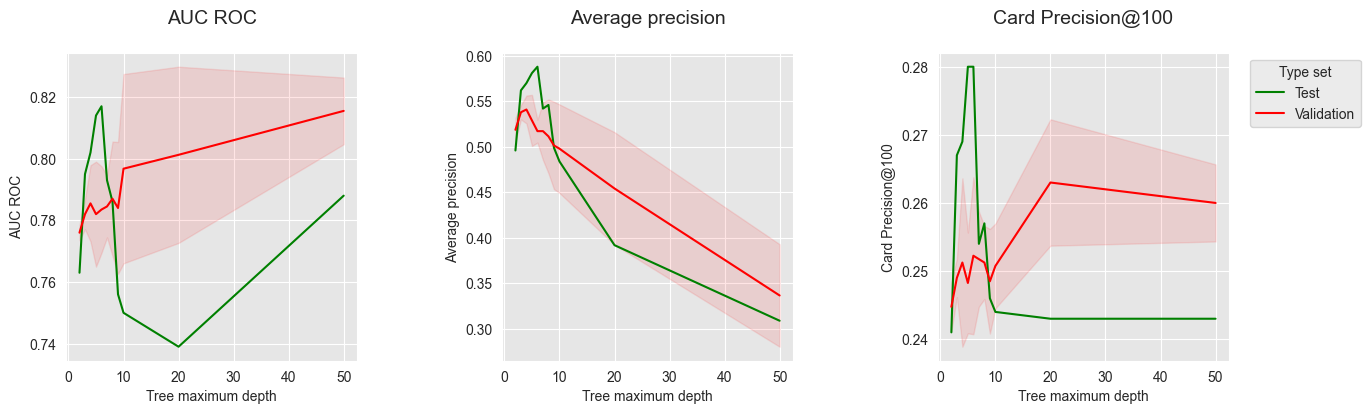

In [15]:
get_performances_plots(
    performances_df_repeated_holdout, 
    performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100'], 
    expe_type_list=['Test','Validation'],expe_type_color_list=['#008000','#FF0000']
)

##### Prequential (predictive sequential) validation

![Prequential validation visualization](https://fraud-detection-handbook.github.io/fraud-detection-handbook/_images/stream_prequential_1block.png)

In [24]:
n_folds=4
delta_assessment=7
import numpy as np
for fold in range(n_folds):
        
        start_date_training_fold=start_date_training-datetime.timedelta(days=fold*delta_assessment)
        
        (train_df, test_df)=get_train_test_set(transactions_df,
                                               start_date_training=start_date_training_fold,
                                               delta_train=delta_train,
                                               delta_delay=delta_delay,
                                               delta_test=delta_assessment)
        print(f'Fold {fold+1}:')
        print('Train:')
        print(np.unique(train_df.TX_DATETIME.dt.date.values))
        print('Val:')
        print(np.unique(test_df.TX_DATETIME.dt.date.values))
        print(50*'-')

Fold 1:
Train:
[datetime.date(2018, 7, 25) datetime.date(2018, 7, 26)
 datetime.date(2018, 7, 27) datetime.date(2018, 7, 28)
 datetime.date(2018, 7, 29) datetime.date(2018, 7, 30)
 datetime.date(2018, 7, 31)]
Val:
[datetime.date(2018, 8, 8) datetime.date(2018, 8, 9)
 datetime.date(2018, 8, 10) datetime.date(2018, 8, 11)
 datetime.date(2018, 8, 12) datetime.date(2018, 8, 13)
 datetime.date(2018, 8, 14)]
--------------------------------------------------
Fold 2:
Train:
[datetime.date(2018, 7, 18) datetime.date(2018, 7, 19)
 datetime.date(2018, 7, 20) datetime.date(2018, 7, 21)
 datetime.date(2018, 7, 22) datetime.date(2018, 7, 23)
 datetime.date(2018, 7, 24)]
Val:
[datetime.date(2018, 8, 1) datetime.date(2018, 8, 2)
 datetime.date(2018, 8, 3) datetime.date(2018, 8, 4)
 datetime.date(2018, 8, 5) datetime.date(2018, 8, 6)
 datetime.date(2018, 8, 7)]
--------------------------------------------------
Fold 3:
Train:
[datetime.date(2018, 7, 11) datetime.date(2018, 7, 12)
 datetime.date(2018, 

In [39]:
def prequential_validation(transactions_df, classifier, 
                           start_date_training, 
                           delta_train=7, 
                           delta_delay=7, 
                           delta_assessment=7,
                           n_folds=4,
                           top_k_list=[100],
                           type_test="Test", parameter_summary=""):

    performances_df_folds=pd.DataFrame()
    
    start_time=time.time() 
    
    for fold in range(n_folds):
        
        start_date_training_fold=start_date_training-datetime.timedelta(days=fold*delta_assessment)
        
        (train_df, test_df)=get_train_test_set(transactions_df,
                                               start_date_training=start_date_training_fold,
                                               delta_train=delta_train,
                                               delta_delay=delta_delay,
                                               delta_test=delta_assessment)
    
        model_and_predictions_dictionary = fit_model_and_get_predictions(classifier, train_df, test_df, 
                                                                     input_features, output_feature)
        
        test_df['predictions']=model_and_predictions_dictionary['predictions_test']
        performances_df_test=performance_assessment(test_df, top_k_list=top_k_list, rounded=False)
        performances_df_test.columns=performances_df_test.columns.values+' '+type_test
        
        train_df['predictions']=model_and_predictions_dictionary['predictions_train']
        performances_df_train=performance_assessment(train_df, top_k_list=top_k_list, rounded=False)
        performances_df_train.columns=performances_df_train.columns.values+' Train'
    
        performances_df_folds=performances_df_folds.append(pd.concat([performances_df_test,performances_df_train],axis=1))
    
    execution_time=time.time()-start_time
    
    performances_df_folds_mean=performances_df_folds.mean()
    performances_df_folds_std=performances_df_folds.std(ddof=0)
    
    performances_df_folds_mean=pd.DataFrame(performances_df_folds_mean).transpose()
    performances_df_folds_std=pd.DataFrame(performances_df_folds_std).transpose()
    performances_df_folds_std.columns=performances_df_folds_std.columns.values+" Std"
    performances_df=pd.concat([performances_df_folds_mean,performances_df_folds_std],axis=1)
    
    performances_df['Execution time']=execution_time
    
    performances_df['Parameters summary']=parameter_summary
    
    return performances_df, performances_df_folds

In [42]:
list_params = [2,3,4,5,6,7,8,9,10,20,50]

start_time=time.time()

performances_df_prequential=pd.DataFrame()

for max_depth in list_params:
    
    print("Computing performances for a decision tree with max_depth="+str(max_depth))
    
    classifier = sklearn.tree.DecisionTreeClassifier(max_depth = max_depth, random_state=0)

    performances_df_prequential=performances_df_prequential.append(
        prequential_validation(
            transactions_df, classifier,
            start_date_training=start_date_training_with_valid, 
            delta_train=delta_train, 
            delta_delay=delta_delay, 
            delta_assessment=delta_test,
            n_folds=4,
            type_test="Validation", parameter_summary=max_depth
        )[0]
    )
    
performances_df_prequential.reset_index(inplace=True,drop=True)

print("Total execution time: "+str(round(time.time()-start_time,2))+"s")

Computing performances for a decision tree with max_depth=2
Computing performances for a decision tree with max_depth=3
Computing performances for a decision tree with max_depth=4
Computing performances for a decision tree with max_depth=5
Computing performances for a decision tree with max_depth=6
Computing performances for a decision tree with max_depth=7
Computing performances for a decision tree with max_depth=8
Computing performances for a decision tree with max_depth=9
Computing performances for a decision tree with max_depth=10
Computing performances for a decision tree with max_depth=20
Computing performances for a decision tree with max_depth=50
Total execution time: 25.19s


In [43]:
performances_df_prequential

,AUC ROC Validation,Average precision Validation,Card Precision@100 Validation,AUC ROC Train,Average precision Train,Card Precision@100 Train,AUC ROC Validation Std,Average precision Validation Std,Card Precision@100 Validation Std,AUC ROC Train Std,Average precision Train Std,Card Precision@100 Train Std,Execution time,Parameters summary
0,0.788729,0.542556,0.251786,0.804017,0.592661,0.405060,0.013002,0.025820,0.009056,0.013094,0.016910,0.044266,1.178998,2
1,0.796158,0.561879,0.261071,0.818312,0.622815,0.425536,0.020599,0.032734,0.010419,0.011607,0.015567,0.038414,1.349005,3
2,0.795400,0.544572,0.258929,0.826143,0.645962,0.428393,0.019287,0.035438,0.006804,0.010063,0.019418,0.037103,1.501999,4
3,0.795453,0.541557,0.260357,0.831581,0.658519,0.435417,0.021132,0.040533,0.002743,0.008127,0.017548,0.035969,1.656997,5
4,0.795845,0.527381,0.260714,0.840004,0.671046,0.436488,0.026844,0.041824,0.002945,0.003866,0.014151,0.035050,1.818000,6
5,0.794677,0.530681,0.259643,0.846888,0.682796,0.441250,0.024150,0.040317,0.003407,0.006209,0.010219,0.033808,2.000002,7
6,0.792602,0.514147,0.256786,0.859928,0.695059,0.444345,0.025662,0.034599,0.003407,0.008068,0.009754,0.037765,2.143999,8
7,0.783230,0.498984,0.256429,0.865290,0.717229,0.451310,0.027762,0.040717,0.004684,0.011461,0.015345,0.034464,2.306998,9
8,0.792561,0.492882,0.253929,0.888427,0.728289,0.452738,0.025956,0.048157,0.004446,0.010588,0.018148,0.035158,2.476002,10
9,0.780368,0.447075,0.261429,0.966437,0.867911,0.504286,0.022188,0.031020,0.003642,0.005807,0.012953,0.042523,4.093999,20


In [44]:
performances_df_prequential['AUC ROC Test']=performances_df['AUC ROC Test']
performances_df_prequential['Average precision Test']=performances_df['Average precision Test']
performances_df_prequential['Card Precision@100 Test']=performances_df['Card Precision@100 Test']

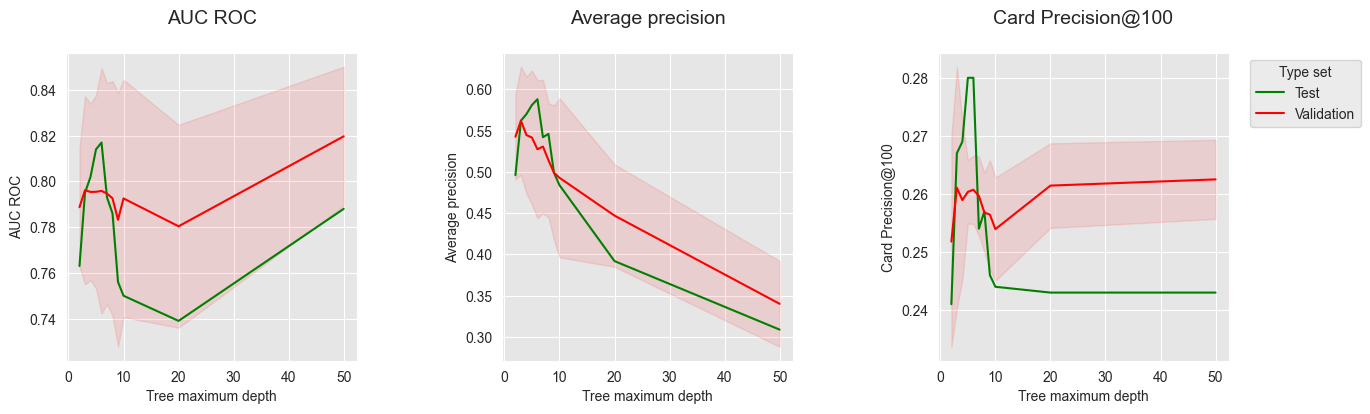

In [45]:
get_performances_plots(performances_df_prequential, 
                       performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100'], 
                       expe_type_list=['Test','Validation'], expe_type_color_list=['#008000','#FF0000'])

In [48]:
list_params = [2,3,4,5,6,7,8,9,10,20,50]

start_time=time.time()

n_folds=4

performances_df_prequential_test=pd.DataFrame()

for max_depth in list_params:
    
    classifier = sklearn.tree.DecisionTreeClassifier(max_depth = max_depth, random_state=0)

    performances_df_prequential_test=performances_df_prequential_test.append(
        prequential_validation(
            transactions_df, classifier, 
            start_date_training=start_date_training 
                +datetime.timedelta(days=delta_test*(n_folds-1)), 
            delta_train=delta_train, 
            delta_delay=delta_delay, 
            delta_assessment=delta_test,
            n_folds=n_folds,
            type_test="Test", parameter_summary=max_depth
        )[0]
    )
    
performances_df_prequential_test.reset_index(inplace=True,drop=True)

print("Total execution time: "+str(round(time.time()-start_time,2))+"s")

Total execution time: 25.84s


In [49]:
performances_df_prequential_test


,AUC ROC Test,Average precision Test,Card Precision@100 Test,AUC ROC Train,Average precision Train,Card Precision@100 Train,AUC ROC Test Std,Average precision Test Std,Card Precision@100 Test Std,AUC ROC Train Std,Average precision Train Std,Card Precision@100 Train Std,Execution time,Parameters summary
0,0.791909,0.541761,0.265000,0.807785,0.592120,0.394643,0.017769,0.031476,0.019756,0.011559,0.017914,0.004088,1.228000,2
1,0.809012,0.578885,0.281429,0.820076,0.623315,0.410714,0.009125,0.014434,0.015940,0.007795,0.015303,0.003712,1.394001,3
2,0.812555,0.601088,0.282500,0.829963,0.645225,0.412500,0.010319,0.020216,0.015199,0.006963,0.015748,0.005285,1.533001,4
3,0.810138,0.600306,0.284286,0.835835,0.658589,0.416071,0.008586,0.016797,0.004286,0.008285,0.015249,0.008353,1.696003,5
4,0.804437,0.585132,0.281429,0.847145,0.671259,0.420000,0.007974,0.005053,0.007626,0.007900,0.016706,0.006145,1.882000,6
5,0.782710,0.554860,0.268929,0.859658,0.692724,0.427500,0.012483,0.011771,0.009813,0.013379,0.012199,0.012990,2.054001,7
6,0.774783,0.544933,0.263571,0.865567,0.708766,0.429643,0.014568,0.003392,0.007593,0.015050,0.009896,0.012951,2.206996,8
7,0.761763,0.520208,0.258571,0.877844,0.721114,0.431786,0.012098,0.012309,0.009949,0.012280,0.014920,0.012792,2.370003,9
8,0.758138,0.504909,0.257500,0.881659,0.737896,0.435357,0.011140,0.013154,0.010467,0.012795,0.012402,0.012990,2.573000,10
9,0.754024,0.439422,0.261071,0.969552,0.878847,0.491429,0.009848,0.034828,0.014335,0.010886,0.026480,0.021500,4.163001,20


In [50]:
performances_df_prequential['AUC ROC Test']=performances_df_prequential_test['AUC ROC Test']
performances_df_prequential['Average precision Test']=performances_df_prequential_test['Average precision Test']
performances_df_prequential['Card Precision@100 Test']=performances_df_prequential_test['Card Precision@100 Test']
performances_df_prequential['AUC ROC Test Std']=performances_df_prequential_test['AUC ROC Test Std']
performances_df_prequential['Average precision Test Std']=performances_df_prequential_test['Average precision Test Std']
performances_df_prequential['Card Precision@100 Test Std']=performances_df_prequential_test['Card Precision@100 Test Std']

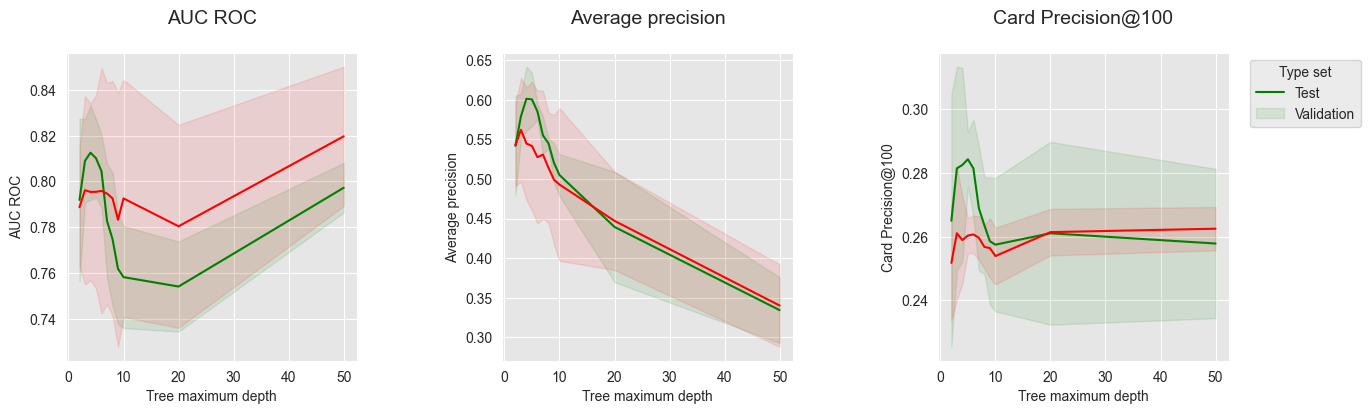

In [51]:
get_performances_plots(performances_df_prequential, 
                       performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100'], 
                       expe_type_list=['Test','Validation'], expe_type_color_list=['#008000','#FF0000'])

##### Integration in Scikit-learn

Adding both prequential validation (prequentialSplit which is already implemented in shared_functions) and the CP metric to the validation and model selection pipelines provided by sklearn (some of the benefits:
* easily parallelize code execution
* rely on sklearn pipelines for data transformation
* rely on different strategies for hyperparameter tuning)

In [5]:
# Only keep columns that are needed as argument to the custom scoring function
# (in order to reduce the serialization time of transaction dataset)
transactions_df_scorer=transactions_df[['CUSTOMER_ID', 'TX_FRAUD','TX_TIME_DAYS']]

card_precision_top_100 = sklearn.metrics.make_scorer(card_precision_top_k_custom, 
                                                     needs_proba=True, 
                                                     top_k=100, 
                                                     transactions_df=transactions_df_scorer)

In [24]:
performance_metrics_list_grid=['roc_auc', 'average_precision', 'card_precision@100']
performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100']

In [25]:
start_time=time.time()

classifier = sklearn.tree.DecisionTreeClassifier()

parameters = {'clf__max_depth':[2,3,4,5,6,7,8,9,10,20,50], 'clf__random_state':[0]}

scoring = {'roc_auc':'roc_auc',
           'average_precision': 'average_precision',
           'card_precision@100': card_precision_top_100,
           }

# sklearn pipeline, prequentialSplit, sklearn gridsearchcv included inside prequential_grid_search function
performances_df_validation=prequential_grid_search(
    transactions_df, classifier, 
    input_features, output_feature,
    parameters, scoring, 
    start_date_training=start_date_training_with_valid,
    n_folds=n_folds,
    expe_type='Validation',
    delta_train=delta_train, 
    delta_delay=delta_delay, 
    delta_assessment=delta_valid,
    performance_metrics_list_grid=performance_metrics_list_grid,
    performance_metrics_list=performance_metrics_list)

print("Validation: Total execution time: "+str(round(time.time()-start_time,2))+"s")

Validation: Total execution time: 9.18s


In [26]:
start_time=time.time()

performances_df_test=prequential_grid_search(
    transactions_df, classifier, 
    input_features, output_feature,
    parameters, scoring, 
    start_date_training=start_date_training+datetime.timedelta(days=(n_folds-1)*delta_test),
    n_folds=n_folds,
    expe_type='Test',
    delta_train=delta_train, 
    delta_delay=delta_delay, 
    delta_assessment=delta_test,
    performance_metrics_list_grid=performance_metrics_list_grid,
    performance_metrics_list=performance_metrics_list)

print("Test: Total execution time: "+str(round(time.time()-start_time,2))+"s")

Test: Total execution time: 5.57s


In [27]:
performances_df_validation.drop(columns=['Parameters','Execution time'], inplace=True)
performances_df=pd.concat([performances_df_test,performances_df_validation],axis=1)

In [28]:
parameters_dict=dict(performances_df['Parameters'])
max_depth=[parameters_dict[i]['clf__max_depth'] for i in range(len(parameters_dict))]
performances_df['Parameters summary']=max_depth

In [29]:
performances_df

,AUC ROC Test,AUC ROC Test Std,Average precision Test,Average precision Test Std,Card Precision@100 Test,Card Precision@100 Test Std,Parameters,Execution time,AUC ROC Validation,AUC ROC Validation Std,Average precision Validation,Average precision Validation Std,Card Precision@100 Validation,Card Precision@100 Validation Std,Parameters summary
0,0.791909,0.017769,0.541761,0.031476,0.265000,0.019756,"{'clf__max_depth': 2, 'clf__random_state': 0}",0.647751,0.788729,0.013002,0.542556,0.025820,0.251786,0.009056,2
1,0.809012,0.009125,0.578885,0.014434,0.281429,0.015940,"{'clf__max_depth': 3, 'clf__random_state': 0}",0.687505,0.796158,0.020599,0.561879,0.032734,0.261071,0.010419,3
2,0.812555,0.010319,0.601088,0.020216,0.282500,0.015199,"{'clf__max_depth': 4, 'clf__random_state': 0}",0.857001,0.795400,0.019287,0.544572,0.035438,0.258929,0.006804,4
3,0.810138,0.008586,0.600306,0.016797,0.284286,0.004286,"{'clf__max_depth': 5, 'clf__random_state': 0}",0.822249,0.795453,0.021132,0.541557,0.040533,0.260357,0.002743,5
4,0.804437,0.007974,0.585132,0.005053,0.281429,0.007626,"{'clf__max_depth': 6, 'clf__random_state': 0}",0.967000,0.795845,0.026844,0.527381,0.041824,0.260714,0.002945,6
5,0.782710,0.012483,0.554860,0.011771,0.268929,0.009813,"{'clf__max_depth': 7, 'clf__random_state': 0}",1.044249,0.794677,0.024150,0.530681,0.040317,0.259643,0.003407,7
6,0.774783,0.014568,0.544933,0.003392,0.263571,0.007593,"{'clf__max_depth': 8, 'clf__random_state': 0}",1.025499,0.792602,0.025662,0.514147,0.034599,0.256786,0.003407,8
7,0.761763,0.012098,0.520208,0.012309,0.258571,0.009949,"{'clf__max_depth': 9, 'clf__random_state': 0}",1.146998,0.783230,0.027762,0.498984,0.040717,0.256429,0.004684,9
8,0.758138,0.011140,0.504909,0.013154,0.257500,0.010467,"{'clf__max_depth': 10, 'clf__random_state': 0}",1.191250,0.792561,0.025956,0.492882,0.048157,0.253929,0.004446,10
9,0.754024,0.009848,0.439422,0.034828,0.261071,0.014335,"{'clf__max_depth': 20, 'clf__random_state': 0}",1.635999,0.780368,0.022188,0.447075,0.031020,0.261429,0.003642,20
